Implementation of
    - Unet from https://arxiv.org/pdf/1910.01113v2.pdf
    - LPD Net from https://arxiv.org/pdf/1707.06474.pdf

In [1]:
import os
import astra
import odl
import numpy as np
import dival
#from dival import get_standard_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import torch.utils.data
import custom_odl_op8 as op
import time 
from torch.optim.lr_scheduler import StepLR
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM
import dival.datasets.lodopab_dataset as lodopab


In [2]:
"""import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import astra
import dival
from matplotlib import pyplot as plt
import torch.utils.data
import odl
import custom_odl_op as op
import custom_odl_op8 as op8
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM

import dival.datasets.lodopab_dataset as lodopab
import time"""

'import numpy as np\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport astra\nimport dival\nfrom matplotlib import pyplot as plt\nimport torch.utils.data\nimport odl\nimport custom_odl_op as op\nimport custom_odl_op8 as op8\nfrom skimage.metrics import peak_signal_noise_ratio as PSNR\nfrom skimage.metrics import structural_similarity as SSIM\n\nimport dival.datasets.lodopab_dataset as lodopab\nimport time'

Set chosen parameters

    BATCH_SIZE:           number of images to process before the optimizer step
    EPOCHS:               number of epochs
    LEARNING_RATE         initial learning rate
    IMG_TO_TRAIN          total number of images per epoch
    DEVICE                device to use for computing
    PRINT_AFTER           number of batches to process before printing an update
    LR_UPDATE_AFTER       number of epochs before a learning rate update
    LR_UPDATE_FACTOR      facter of the learning rate update

In [3]:
"""
constants from the dataset:
input_size: 1000*513
output_size: 362*362

train_len = 35820
validation_len = 3522
test_len = 3553
"""


BATCH_SIZE = 2
EPOCHS = 10
LEARNING_RATE = 0.001
IMG_TO_TRAIN = 2000
IMG_TO_TEST = 50
IMG_TO_VAL = 3522
DEVICE = "cuda:1"
PRINT_AFTER = 25
LR_UPDATE_AFTER = 5
LR_UPDATE_FACTOR = 0.1
SAVE_AFTER = 2

Definition of the dataset and dataloader

In [4]:
dataset = lodopab.LoDoPaBDataset(impl= 'astra_cpu')

trainset = torch.utils.data.Subset(
    dataset.create_torch_dataset('train'),
    list(range(IMG_TO_TRAIN))) 
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

testset = torch.utils.data.Subset(
    dataset.create_torch_dataset('test'),
    list(range(IMG_TO_TEST))) 
testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

evalset = torch.utils.data.Subset(
    dataset.create_torch_dataset('test'),
    list(range(IMG_TO_VAL)))
evalloader = torch.utils.data.DataLoader(
    evalset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

Definition the helper functions

plot
    sinogram
    FBP + PSNR + SSIM
    model output + PSNR / SSIM
    ground truth

In [5]:
fbp_op = odl.tomo.fbp_op(dataset.ray_trafo, filter_type='Ram-Lak', frequency_scaling=1.0)
#fbp=odl.tomo.analytic.filtered_back_projection.fbp_op(dataset.get_ray_trafo())

FBP = op.OperatorAsModule(fbp_op)

def plot_Unet(n, model, part = "test"):
        sinogram, ground_truth = dataset.get_samples(slice(n,n+1,1), part=part) #numpy, 1 x N x M
        sinogram = torch.from_numpy(sinogram[0])
        ground_truth = torch.from_numpy(ground_truth[0])
        fbp_out = FBP(sinogram.unsqueeze(0).unsqueeze(0)).squeeze()
        out = model(sinogram.unsqueeze(0).unsqueeze(0).to(DEVICE)).squeeze().cpu().detach() #torch N x M
        min = torch.min(torch.tensor([torch.min(sinogram), torch.min(fbp_out), torch.min(out), torch.min(ground_truth)]))
        max = torch.max(torch.tensor([torch.max(sinogram), torch.max(fbp_out), torch.max(out), torch.max(ground_truth)]))
                
        psnr_fbp = PSNR(ground_truth.squeeze().numpy(), fbp_out.numpy())
        psnr_model = PSNR(ground_truth.squeeze().numpy(), out.numpy())
        ssim_fbp = SSIM(ground_truth.squeeze().numpy(), fbp_out.numpy())
        ssim_model = SSIM(ground_truth.squeeze().numpy(), out.numpy())

        plt.figure().set_dpi(150)

        plt.subplot(1, 4, 1)
        plt.imshow(sinogram.numpy(), vmin=min, vmax=max)
        plt.title("sinogram")
        
        plt.subplot(1, 4, 2)
        plt.imshow(fbp_out.numpy(), vmin=min, vmax=max)
        plt.title("FBP")
        plt.figtext(0.2, 0.1, "PSNR:" + str(psnr_fbp) + "\nSSIM:"+ str(ssim_fbp))
        
        plt.subplot(1, 4, 3)
        plt.imshow(out.numpy(), vmin=min, vmax=max)
        plt.title("model output")
        plt.figtext(0.6, 0.1, "PSNR:"+ str(psnr_model) + "\nSSIM:" + str(ssim_model))
        
        plt.subplot(1, 4, 4)
        plt.imshow(ground_truth.numpy(), vmin=min, vmax=max)
        plt.title("ground truth")
        
        plt.suptitle("Unet Plots for n=" + str(n))

        
def plot_LPD(n, model, part = "test"):
        sinogram, ground_truth = dataset.get_samples(slice(n,n+1,1), part=part) #numpy, 1 x N x M
        sinogram = torch.from_numpy(sinogram[0])
        ground_truth = torch.from_numpy(ground_truth[0])
        out = model(sinogram.unsqueeze(0).unsqueeze(0).to(DEVICE)).squeeze().cpu().detach() #torch N x M
        min = torch.min(torch.tensor([torch.min(sinogram), torch.min(out), torch.min(ground_truth)]))
        max = torch.max(torch.tensor([torch.max(sinogram), torch.max(out), torch.max(ground_truth)]))
                
        psnr_model = PSNR(ground_truth.squeeze().numpy(), out.numpy())
        ssim_model = SSIM(ground_truth.squeeze().numpy(), out.numpy())

        plt.figure().set_dpi(150)

        plt.subplot(1, 3, 1)
        plt.imshow(sinogram.numpy(), vmin=min, vmax=max)
        plt.title("sinogram")
        
        plt.subplot(1, 3, 2)
        plt.imshow(out.numpy(), vmin=min, vmax=max)
        plt.title("model output")
        plt.figtext(0.4, 0.1, "PSNR:"+ str(psnr_model) + "\nSSIM:" + str(ssim_model))
        
        plt.subplot(1, 3, 3)
        plt.imshow(ground_truth.numpy(), vmin=min, vmax=max)
        plt.title("ground truth")
        
        plt.suptitle("LPD Plots")
        
        
        
def evaluate(model, loader):
    psnr = 0
    ssim = 0
    nb = 0
    for batch_id, samples in enumerate(loader):
        sinogram, ground_truth = samples
        out = model(sinogram.unsqueeze(1).to(DEVICE)).squeeze(dim=1).cpu().detach()
        
        for n in range(sinogram.shape[0]):

            psnr += PSNR(ground_truth.numpy()[n], out.numpy()[n])
            ssim += SSIM(ground_truth.numpy()[n], out.numpy()[n])
        if batch_id % 3 == 0:
            print(str(batch_id + 1)+"/"+str(len(loader)))
        nb += sinogram.shape[0]
    print("psnr:", psnr/nb)
    print("ssim:", ssim/nb)
    return psnr/nb, ssim/nb

#plot_Unet(10, model)
#plot_LPD(10, model)
#evaluate(model, evalloader)

Definition of the Nets

In [6]:
class UNet_5Layer(nn.Module):
    def __init__(self, m = 16, n = 32, o = 64, p = 64, q = 128):
        super(UNet_5Layer, self).__init__()
        #U-net from https://arxiv.org/pdf/1910.01113v2.pdf

        self.conv1 = nn.Conv2d(1, m, 3)
        self.norm1 = torch.nn.BatchNorm2d(m)
        
        self.conv2 = nn.Conv2d(m, n, 5, stride = 2)
        self.norm2 = torch.nn.BatchNorm2d(n)
        self.conv3 = nn.Conv2d(n, n, 3)
        self.norm3 = torch.nn.BatchNorm2d(n)
        
        self.conv4 = nn.Conv2d(n, o, 3, stride = 2)
        self.norm4 = torch.nn.BatchNorm2d(o)
        self.conv5 = nn.Conv2d(o, o, 3)
        self.norm5 = torch.nn.BatchNorm2d(o)
        
        self.conv6 = nn.Conv2d(o, p, 3, stride = 2)
        self.norm6 = torch.nn.BatchNorm2d(p)
        self.conv7 = nn.Conv2d(p, p, 3)
        self.norm7 = torch.nn.BatchNorm2d(p)

        self.conv8 = nn.Conv2d(p, q, 3, stride = 2)
        self.norm8 = torch.nn.BatchNorm2d(q)
        self.conv9 = nn.Conv2d(q, q, 3)
        self.norm9 = torch.nn.BatchNorm2d(q)
        self.up4 = nn.Upsample(scale_factor=2) #nn.Upsample([74, 74])
        self.conv10 = nn.Conv2d(q, p, 3)
        self.norm10 = torch.nn.BatchNorm2d(p)
        
        self.conv11 = nn.Conv2d(p+4, p, 3)
        self.norm11 = torch.nn.BatchNorm2d(p)
        self.up3 = nn.Upsample(scale_factor=2)
        self.conv12 = nn.Conv2d(p, o, 3)
        self.norm12 = torch.nn.BatchNorm2d(o)
        
        self.conv13 = nn.Conv2d(o+4, o, 3)
        self.norm13 = torch.nn.BatchNorm2d(o)
        self.up2 = nn.Upsample(scale_factor=2)
        self.conv14 = nn.Conv2d(o, n, 3)
        self.norm14 = torch.nn.BatchNorm2d(n)
        
        self.conv15 = nn.Conv2d(n+4, n, 3)
        self.norm15 = torch.nn.BatchNorm2d(n)
        self.up2 = nn.Upsample(scale_factor=2)
        self.conv16 = nn.Conv2d(n, m, 3)
        self.norm16 = torch.nn.BatchNorm2d(m)
        
        self.conv17 = nn.Conv2d(m+4, 1, 1)
        
        self.skip1 = nn.Conv2d(m, 4, 1)
        self.skip2 = nn.Conv2d(n, 4, 1)
        self.skip3 = nn.Conv2d(o, 4, 1)
        self.skip4 = nn.Conv2d(p, 4, 1)

    def forward(self, inp):
        with torch.cuda.device(DEVICE):
            a = F.leaky_relu(self.norm1(self.conv1(inp)), negative_slope=0.2)#torch.Size([1, 16, 360, 360])


            b = F.leaky_relu(self.norm2(self.conv2(a)), negative_slope=0.2)
            b = F.leaky_relu(self.norm3(self.conv3(b)), negative_slope=0.2)#torch.Size([1, 32, 176, 176])

            c = F.leaky_relu(self.norm4(self.conv4(b)), negative_slope=0.2)
            c = F.leaky_relu(self.norm5(self.conv5(c)), negative_slope=0.2) #torch.Size([1, 64, 85, 85])

            d = F.leaky_relu(self.norm6(self.conv6(c)), negative_slope=0.2)
            d = F.leaky_relu(self.norm7(self.conv7(d)), negative_slope=0.2) #torch.Size([1, 64, 40, 40])

            e = F.leaky_relu(self.norm8(self.conv8(d)), negative_slope=0.2)
            e = F.leaky_relu(self.norm9(self.conv9(e)), negative_slope=0.2)
            e = F.leaky_relu(self.norm10(self.conv10(self.up4(e))), negative_slope=0.2) #torch.Size([1, 64, 32, 32])

            d = self.skip4(d[:,:,4:-4, 4:-4])

            d = F.leaky_relu(self.norm11(self.conv11(torch.cat((d, e), 1))), negative_slope=0.2)
            d = F.leaky_relu(self.norm12(self.conv12(self.up3(d))), negative_slope=0.2)#torch.Size([1, 64, 58, 58])

            c = self.skip3(c[:,:,13:-14,13:-14])

            c = F.leaky_relu(self.norm13(self.conv13(torch.cat((c, d), 1))), negative_slope=0.2)
            c = F.leaky_relu(self.norm14(self.conv14(self.up2(c))), negative_slope=0.2)#torch.Size([1, 32, 110, 110])

            b = self.skip2(b[:,:,33:-33,33:-33])

            b = F.leaky_relu(self.norm15(self.conv15(torch.cat((b, c), 1))), negative_slope=0.2)
            b = F.leaky_relu(self.norm16(self.conv16(self.up2(b))), negative_slope=0.2)#torch.Size([1, 16, 214, 214])

            a = self.skip1(a[:,:,73:-73,73:-73])
            a = torch.sigmoid(self.conv17(torch.cat((a,b), 1)))
    #         out = a
            out = F.interpolate(a, [362,362])

        return out
        
        

In [7]:
class dual_iterate(nn.Module):
    def __init__(self, N_dual):
        super(dual_iterate, self).__init__()
        self.d_modules = nn.Sequential(
            nn.Conv2d(2+N_dual,32, 3, padding = 1),
            nn.PReLU(),
            nn.Conv2d(32 ,32, 3, padding = 1),
            nn.PReLU(),
            nn.Conv2d(32 ,5, 3, padding = 1)
        )
        
    def forward(self, h, f, g):
        out = self.d_modules(torch.cat((h, f[:, 1:2, :, :], g), dim=1))
        return out + h

class primal_iterate(nn.Module):
    def __init__(self, N_primal):
        super(primal_iterate, self).__init__()
        self.p_modules = nn.Sequential(
            nn.Conv2d(1+N_primal,32, 3, padding = 1),
            nn.PReLU(),
            nn.Conv2d(32 ,32, 3, padding = 1),
            nn.PReLU(),
            nn.Conv2d(32 ,5, 3, padding = 1)
        )
        
    def forward(self, inp, f):
        out = self.p_modules(torch.cat((inp[:, 0:1, :, :], f), 1))
        return out + f
    
class LPD_Net(nn.Module):
    def __init__(self, I = 10,  N_primal = 5, N_dual = 5):
        super(LPD_Net, self).__init__()
        self.I = I
        self.N_primal = N_primal
        self.N_dual = N_dual
        self.primal_iterates = nn.ModuleList([primal_iterate(N_primal) for i in range(I)])
        self.dual_iterates = nn.ModuleList([dual_iterate(N_dual) for i in range(I)])
        self.T = op.OperatorAsModule(dataset.get_ray_trafo())
        self.Tstar = op.OperatorAsModule(dataset.get_ray_trafo().adjoint)
        self.dual_iterates.to(DEVICE)
        self.primal_iterates.to(DEVICE)

    def forward(self, g):
        with torch.cuda.device(DEVICE):

            #g = g.reshape(1, 1, 1000, 513)
            h = torch.zeros(g.shape[0], self.N_dual, 1000, 513).to(DEVICE)
            f = torch.zeros(g.shape[0], self.N_primal, 362, 362).to(DEVICE)
            T_f = self.T(f)
            """print(g.shape)
            print(f.shape)
            print(h.shape)
            print(T_f.shape)
            print(T_f[:, 1:2, :, :].shape)"""
            for i in range(self.I):
                """print(h.shape)
                print(T_f.shape)
                print(g.shape)"""
                h = self.dual_iterates[i](h, T_f, g)
                Tstar_h = self.Tstar(h)
                f = self.primal_iterates[i](Tstar_h, f)
                T_f = self.T(f)
        return f[:,0:1,:,:]


get Net and Object
    net is just the net
    model is a function of the net which takes the sinogram as input

In [8]:
#net = UNet_5Layer().to(DEVICE)
#model = lambda x : net(FBP(x))
net = LPD_Net(I=10).to(DEVICE)
model = lambda x : net(x)

Optimizer
    

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
start_time = time.time()

for epoch in range(0, EPOCHS):
    running_loss = 0.0
    for batch_id, sample in enumerate(trainloader):
        
        sinograms, ground_truths = sample
        sinograms = torch.unsqueeze(sinograms, 1).to(DEVICE) 
        ground_truths = torch.unsqueeze(ground_truths, 1).to(DEVICE)
                
        optimizer.zero_grad()
        outputs = model(sinograms)

        loss = nn.functional.mse_loss(outputs, ground_truths)
        # print("loss: ", loss)
        loss.backward()
        optimizer.step()
        
        running_loss += float(loss)
        if batch_id % PRINT_AFTER == PRINT_AFTER-1:    # print every PRINT_AFTER mini-batches
            print('[%d, %s] loss: %.5f' %
                  (epoch + 1, str(batch_id + 1)+"/"+str(len(trainloader)), running_loss/ PRINT_AFTER))
            running_loss = 0.0
        
        if epoch % LR_UPDATE_AFTER == LR_UPDATE_AFTER-1:
            LEARNING_RATE *= LR_UPDATE_FACTOR
            optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
        
        if epoch % SAVE_AFTER == SAVE_AFTER-1:
            torch.save(net.state_dict(), '../../../../../scratch/s21gpu1project/saves/LPD_210621.pth')
        
end_time = time.time()
run_time = (end_time - start_time)/60
print("run time in minutes: ", run_time)
print('Finished Training')

[1, 25/1000] loss: 0.05426
[1, 50/1000] loss: 0.01400
[1, 75/1000] loss: 0.01292
[1, 100/1000] loss: 0.01111
[1, 125/1000] loss: 0.00914
[1, 150/1000] loss: 0.00794
[1, 175/1000] loss: 0.00817
[1, 200/1000] loss: 0.00630
[1, 225/1000] loss: 0.00500
[1, 250/1000] loss: 0.00327
[1, 275/1000] loss: 0.00231
[1, 300/1000] loss: 0.00195
[1, 325/1000] loss: 0.00177
[1, 350/1000] loss: 0.00147
[1, 375/1000] loss: 0.00161
[1, 400/1000] loss: 0.00228
[1, 425/1000] loss: 0.00196
[1, 450/1000] loss: 0.00148
[1, 475/1000] loss: 0.00122
[1, 500/1000] loss: 0.00128
[1, 525/1000] loss: 0.00124
[1, 550/1000] loss: 0.00094
[1, 575/1000] loss: 0.00084
[1, 600/1000] loss: 0.00076
[1, 625/1000] loss: 0.00092
[1, 650/1000] loss: 0.00086
[1, 675/1000] loss: 0.00076
[1, 700/1000] loss: 0.00081
[1, 725/1000] loss: 0.00179
[1, 750/1000] loss: 0.00275
[1, 775/1000] loss: 0.00155
[1, 800/1000] loss: 0.00195
[1, 825/1000] loss: 0.00179
[1, 850/1000] loss: 0.00140
[1, 875/1000] loss: 0.00097
[1, 900/1000] loss: 0.0

[7, 775/1000] loss: 3479457.14000
[7, 800/1000] loss: 3495065.92000
[7, 825/1000] loss: 3534631.92000
[7, 850/1000] loss: 3495560.30000
[7, 875/1000] loss: 3555438.39000
[7, 900/1000] loss: 3553565.84000
[7, 925/1000] loss: 3526909.95000
[7, 950/1000] loss: 3523502.46000
[7, 975/1000] loss: 3528788.33000
[7, 1000/1000] loss: 3460077.27000
[8, 25/1000] loss: 3565715.63000
[8, 50/1000] loss: 3524722.97000
[8, 75/1000] loss: 3518920.71000
[8, 100/1000] loss: 3576655.66000
[8, 125/1000] loss: 3492931.61000
[8, 150/1000] loss: 3599580.44000
[8, 175/1000] loss: 3533938.20000
[8, 200/1000] loss: 3503469.48000
[8, 225/1000] loss: 3535978.67000
[8, 250/1000] loss: 3543711.51000
[8, 275/1000] loss: 3561051.00000
[8, 300/1000] loss: 3505038.35000
[8, 325/1000] loss: 3509485.67000
[8, 350/1000] loss: 3511155.99000
[8, 375/1000] loss: 3572715.68000
[8, 400/1000] loss: 3548810.70000
[8, 425/1000] loss: 3559909.69000
[8, 450/1000] loss: 3511971.87000
[8, 475/1000] loss: 3511123.57000
[8, 500/1000] lo

save net manually

In [ ]:
torch.save(net.state_dict(), '../../../../../scratch/s21gpu1project/saves/LPD_net200621.pth')

load Unet

In [7]:
#loaded_model =  UNet_5Layer().to(DEVICE)
net.load_state_dict(torch.load('../../../../../scratch/s21gpu1project/saves/LPD_210621.pth'))

<All keys matched successfully>

In [ ]:
torch.cuda.empty_cache()

'plot_Unet(2, model)\nplot_Unet(5, model)\nplot_Unet(42, model)\nplot_Unet(666, model)\nplot_Unet(1337, model)\nplot_Unet(223, model)\nplot_Unet(2239, model)\nplot_Unet(1234, model)\nplot_Unet(123, model)\n'

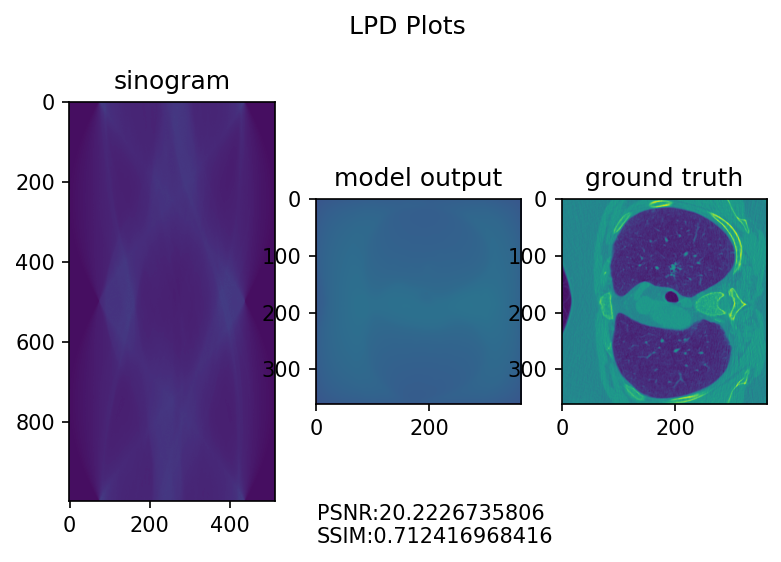

In [11]:
plot_LPD(20, model)
"""plot_Unet(2, model)
plot_Unet(5, model)
plot_Unet(42, model)
plot_Unet(666, model)
plot_Unet(1337, model)
plot_Unet(223, model)
plot_Unet(2239, model)
plot_Unet(1234, model)
plot_Unet(123, model)
"""

In [ ]:
evaluate(model, evalloader)

In [ ]:
evaluate(FBP, evalloader)